In [36]:
BiocManager::install("clusterProfiler")
# install.packages("devtools")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'missMDA'
also installing the dependencies 'zip', 'ucminf', 'SparseM', 'MatrixModels', 'sp', 'openxlsx', 'ordinal', 'carData', 'abind', 'pbkrtest', 'quantreg', 'maptools', 'rio', 'pan', 'jomo', 'car', 'ellipse', 'flashClust', 'leaps', 'scatterplot3d', 'mitml', 'FactoMineR', 'mice'

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'BH', 'bibtex', 'BiocParallel', 'bit', 'blob', 'boot', 'broom',
  'callr', 'caTools', 'data.table', 'DBI', 'doRNG', 'evaluate', 'farver',
  'foreign', 'future', 'future.apply', 'GenomicFeatures', 'ggridges', 'gh',
  'gmp', 'gplots', 'gRain', 'gRbase', 'Gviz', 'hms', 'IRanges', 'IRkernel',
  'knitr', 'leiden', 'limma', 'loo', 'MASS', 'metap', 'mime', 'missMethyl',
  'multcomp', 'mvtnorm', 'nlme', 'pkgmaker', 'prettyunits', 'RcppArmadillo',
  'RCurl', 'Rdpack', 'repr', 'reticulate', 'Rhtslib', 'rlang', 'rmarkdown',
  'rngtools', 

In [1]:
require(GEOquery) # this can cause some issues with different R version
require(data.table)
require(impute)
require(tidyverse)
require(minfi)
require(Gviz)
require(missMethyl)
require(limma)
require(seqlm)
require(sva)
require(gprofiler2)
require(GOsummaries)
require(missMDA)

Loading required package: GEOquery
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contai

In [2]:
#Loading a GDS file with GEOquery
met <- getGEO('GSE71955', destdir=".", GSEMatrix= TRUE)

Found 1 file(s)
GSE71955_series_matrix.txt.gz
Using locally cached version: ./GSE71955_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL13534 found here:
./GPL13534.soft 
Warning message:
"65 parsing failures.
   row     col           expected     actual         file
485513 SPOT_ID 1/0/T/F/TRUE/FALSE rs10796216 literal data
485514 SPOT_ID 1/0/T/F/TRUE/FALSE rs715359   literal data
485515 SPOT_ID 1/0/T/F/TRUE/FALSE rs1040870  literal data
485516 SPOT_ID 1/0/T/F/TRUE/FALSE rs10936224 literal data
485517 SPOT_ID 1/0/T/F/TRUE/FALSE rs213028   literal data
...... ....... .................. .......... ............
See problems(...) for more details.
"

## Parsing the data

In [3]:
met

$GSE71955_series_matrix.txt.gz
ExpressionSet (storageMode: lockedEnvironment)
assayData: 390142 features, 135 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: GSM1847992 GSM1847993 ... GSM1848134 (135 total)
  varLabels: title geo_accession ... tissue:ch1 (41 total)
  varMetadata: labelDescription
featureData
  featureNames: cg00000029 cg00000108 ... ch.X.97737721F (390142 total)
  fvarLabels: ID Name ... SPOT_ID (37 total)
  fvarMetadata: Column Description labelDescription
experimentData: use 'experimentData(object)'
  pubMedIds: 26459776 
Annotation: GPL13534 


In [4]:
key <- data.table(pData(met[[1]]))
mat <- as.matrix(exprs(met[[1]]))
anno <- data.table(fData(met[[1]]))

In [5]:
# This part just checks if the sample information is in correct order
stopifnot(colnames(mat)==key$geo_accession)
stopifnot(rownames(mat)==anno$ID)

In [6]:
dim(key)
dim(mat)
dim(anno)

[1] 135  41

[1] 390142    135

[1] 390142     37

In [7]:
head(key)
head(mat)
head(anno)

title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,contact_zip/postal_code,contact_country,supplementary_file,supplementary_file.1,data_row_count,age:ch1,cell type:ch1,diagnosis:ch1,gender:ch1,tissue:ch1
gDNA_CD4_Control_rep1,GSM1847992,Public on Nov 06 2015,Aug 11 2015,Nov 06 2015,genomic,1,"Genomic DNA, CD4 cells, healthy control",Homo sapiens,tissue: blood,...,50411,Estonia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847992/suppl/GSM1847992_9407210137_R02C02_Grn.idat.gz,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847992/suppl/GSM1847992_9407210137_R02C02_Red.idat.gz,390142,54,CD4 T cells,Healthy,Female,blood
gDNA_CD4_Control_rep2,GSM1847993,Public on Nov 06 2015,Aug 11 2015,Nov 06 2015,genomic,1,"Genomic DNA, CD4 cells, healthy control",Homo sapiens,tissue: blood,...,50411,Estonia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847993/suppl/GSM1847993_9407210137_R02C01_Grn.idat.gz,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847993/suppl/GSM1847993_9407210137_R02C01_Red.idat.gz,390142,37,CD4 T cells,Healthy,Female,blood
gDNA_CD4_Control_rep3,GSM1847994,Public on Nov 06 2015,Aug 11 2015,Nov 06 2015,genomic,1,"Genomic DNA, CD4 cells, healthy control",Homo sapiens,tissue: blood,...,50411,Estonia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847994/suppl/GSM1847994_9407210103_R02C02_Grn.idat.gz,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847994/suppl/GSM1847994_9407210103_R02C02_Red.idat.gz,390142,38,CD4 T cells,Healthy,Female,blood
gDNA_CD4_Control_rep4,GSM1847995,Public on Nov 06 2015,Aug 11 2015,Nov 06 2015,genomic,1,"Genomic DNA, CD4 cells, healthy control",Homo sapiens,tissue: blood,...,50411,Estonia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847995/suppl/GSM1847995_9407210103_R02C01_Grn.idat.gz,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847995/suppl/GSM1847995_9407210103_R02C01_Red.idat.gz,390142,49,CD4 T cells,Healthy,Female,blood
gDNA_CD4_Control_rep5,GSM1847996,Public on Nov 06 2015,Aug 11 2015,Nov 06 2015,genomic,1,"Genomic DNA, CD4 cells, healthy control",Homo sapiens,tissue: blood,...,50411,Estonia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847996/suppl/GSM1847996_9407210105_R02C02_Grn.idat.gz,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847996/suppl/GSM1847996_9407210105_R02C02_Red.idat.gz,390142,37,CD4 T cells,Healthy,Female,blood
gDNA_CD4_Control_rep6,GSM1847997,Public on Nov 06 2015,Aug 11 2015,Nov 06 2015,genomic,1,"Genomic DNA, CD4 cells, healthy control",Homo sapiens,tissue: blood,...,50411,Estonia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847997/suppl/GSM1847997_9407210105_R02C01_Grn.idat.gz,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM1847nnn/GSM1847997/suppl/GSM1847997_9407210105_R02C01_Red.idat.gz,390142,51,CD4 T cells,Healthy,Female,blood


,GSM1847992,GSM1847993,GSM1847994,GSM1847995,GSM1847996,GSM1847997,GSM1847998,GSM1847999,GSM1848000,GSM1848001,...,GSM1848125,GSM1848126,GSM1848127,GSM1848128,GSM1848129,GSM1848130,GSM1848131,GSM1848132,GSM1848133,GSM1848134
cg00000029,0.6891052,0.6855117,0.7597718,0.6572791,0.6340425,0.7258857,0.6561995,0.6140348,0.6705295,0.7232441,...,0.7317703,0.6066616,0.6687542,0.6851246,0.6411103,0.6600936,0.6927672,0.5998506,0.6549124,0.6464985
cg00000108,0.9160698,0.9200489,0.9206866,0.9461083,0.9489535,0.9469503,0.9432923,0.9461049,0.9514329,0.9103172,...,0.9463530,0.9397670,0.9175556,0.8940734,0.9402696,0.9259952,0.9387162,0.9417357,0.9282697,0.9339856
cg00000109,0.7873342,0.8048066,0.8845278,0.8698111,0.7664764,0.8609239,0.7577009,0.8502382,0.8452617,0.8593344,...,0.8507064,0.8330993,0.8687290,0.6815520,0.8919813,0.8183883,0.8305999,0.7837336,0.8474653,0.8724345
cg00000165,0.3040812,0.2756206,0.2609209,0.2673450,0.2699676,0.2554553,0.2899948,0.2448319,0.3397843,0.2655507,...,0.2705401,0.3058952,0.2573734,0.3625476,0.3735513,0.2549220,0.2344297,0.2851157,0.2767348,0.3425648
cg00000236,0.8410680,0.8732100,0.8568683,0.8591934,0.8731590,0.8945298,0.8210283,0.8828818,0.8472972,0.8646884,...,0.8975462,0.7696826,0.8282152,0.8304289,0.8561097,0.8383581,0.8133452,0.8100074,0.8274307,0.8297456
cg00000289,0.5805570,0.6758169,0.6206408,0.7337596,0.6082721,0.6131171,0.7573842,0.6958804,0.6061886,0.5811683,...,0.5462894,0.6545747,0.6653911,0.5345543,0.6078303,0.6448371,0.6843967,0.7144998,0.6938663,0.5793450


ID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,...,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS,RANGE_START,RANGE_END,RANGE_GB,SPOT_ID
cg00000029,cg00000029,14782418,AACTATACTAACRAAAAAATATCCAAAAAACACTAACRTATAAAAATTTC,NA,,II,,,TTTTTTAGATAAGGATATCCAGGCGATGAGGAAGTTTTACTTCTGGGAACAGCCTGGATA[CG]AAACCTTCACACGTCAGTGTCTTTTGGACATTTTCTCGTCAGTACAGCCCTGTTGAATGT,...,,NA,,16:53467838-53469685,Promoter_Associated,TRUE,53468112,53468235,NC_000016.9,NA
cg00000108,cg00000108,12709357,ATACAATAAAACAAACCTAAAATAATCCTAACTCCRCTATCATCCTAACC,NA,,II,,,TCCATTTTGAAGGAAAAAAATGAAGGCTCTGAAAGTGTAAATCGCTTACTGAAGGGCACA[CG]GCCAGGATGACAGCGGAGCCAGGATCACCCCAGGTCTGTCTCATTGCATATGTCATGGCT,...,,NA,,,,NA,37459206,37459329,NC_000003.11,NA
cg00000109,cg00000109,59755374,CAATACTAACAAACACATATACCCCCCCACAAATCTTAACTTCTAAATAC,NA,,II,,,GCCTTAGTCCTGAATGAGCCATTTCTCTAAGAAGTCCTGGCTTCTTTTTTAATAGAGAAT[CG]TATTTAGAAGCCAAGATCTGTGGGGGGGTACATGTGCCTGTTAGTATTGCAGTTGTGCCT,...,,NA,,,,NA,171916037,171916160,NC_000003.11,NA
cg00000165,cg00000165,12637463,CAAAATCTATTAATACAATAACTTTTAATAAAACAACTAAAACACACATC,NA,,II,,,CTAAGTGCAGTCAGGATCTGTTAGTACAGTGGCTTTTGATGGAACAGCTGAGGCACACAT[CG]CCCGTGGCATGGACTCCGGGGCCGAACGCTCACGACCAAGACTTTTGCCCTTTTGAAATG,...,CDMR,TRUE,1:90967262-90967361,,,NA,91194674,91194797,NC_000001.10,NA
cg00000236,cg00000236,12649348,TATAACRTCATATTAAAAAAAACRATCTAACCCACCAATTTATACATCAC,NA,,II,,,CTCAGCGACAGTGTAGCGTCATGTTAGAGGAGACGATCTGACCCACCAGTTTGTACATCA[CG]TCCTGCATGTCCCACACCATTTTTTCATGACCTTGTAATATACTGGTCTCTGTGCTATAG,...,,NA,,,,NA,42263294,42263417,NC_000008.10,NA
cg00000289,cg00000289,18766346,ATCTACTATATTCATTTCTCCAATCTCATATCCATTTTAATATAAAAATC,NA,,II,,,CAAGTGAGCTAGCAAACACACATGCACCAATGTGCCTTTTGACAAGAGTACCCCCTACCC[CG]ACTCCCACACCAAAATGGACATGAGATTGGAGAAATGAATACAGCAGATGGAACAGATAG,...,,NA,,,,NA,69341139,69341262,NC_000014.8,NA


In [8]:
colnames(anno)

[1] "ID"                          "Name"                       
 [3] "AddressA_ID"                 "AlleleA_ProbeSeq"           
 [5] "AddressB_ID"                 "AlleleB_ProbeSeq"           
 [7] "Infinium_Design_Type"        "Next_Base"                  
 [9] "Color_Channel"               "Forward_Sequence"           
[11] "Genome_Build"                "CHR"                        
[13] "MAPINFO"                     "SourceSeq"                  
[15] "Chromosome_36"               "Coordinate_36"              
[17] "Strand"                      "Probe_SNPs"                 
[19] "Probe_SNPs_10"               "Random_Loci"                
[21] "Methyl27_Loci"               "UCSC_RefGene_Name"          
[23] "UCSC_RefGene_Accession"      "UCSC_RefGene_Group"         
[25] "UCSC_CpG_Islands_Name"       "Relation_to_UCSC_CpG_Island"
[27] "Phantom"                     "DMR"                        
[29] "Enhancer"                    "HMM_Island"                 
[31] "Regulatory_Feature_Name"     "Regulatory_Feature_Group"   
[33] "DHS"                         "RANGE_START"                
[35] "RANGE_END"                   "RANGE_GB"                   
[37] "SPOT_ID"

In [9]:
# head(key, 5)
# key %>% distinct(`tissue:ch1`)
key <- key %>% mutate("sample" = rownames(key)) %>% select("sample" = sample, "title" = title, "age" = `age:ch1`,
                 "cell_type" = `cell type:ch1`, "diagnosis" = `diagnosis:ch1`, "geo" = geo_accession)
head(key)

sample,title,age,cell_type,diagnosis,geo
1,gDNA_CD4_Control_rep1,54,CD4 T cells,Healthy,GSM1847992
2,gDNA_CD4_Control_rep2,37,CD4 T cells,Healthy,GSM1847993
3,gDNA_CD4_Control_rep3,38,CD4 T cells,Healthy,GSM1847994
4,gDNA_CD4_Control_rep4,49,CD4 T cells,Healthy,GSM1847995
5,gDNA_CD4_Control_rep5,37,CD4 T cells,Healthy,GSM1847996
6,gDNA_CD4_Control_rep6,51,CD4 T cells,Healthy,GSM1847997


# Remove SNP-containing probes

In [10]:
anno_snp <- anno %>% filter(str_detect(Probe_SNPs, "rs") | str_detect(Probe_SNPs_10, "rs"))
nrow(anno_snp)
nrow(anno)
anno <- anno %>% anti_join(anno_snp)
nrow(anno)

[1] 61757

[1] 390142

Joining, by = c("ID", "Name", "AddressA_ID", "AlleleA_ProbeSeq", "AddressB_ID", "AlleleB_ProbeSeq", "Infinium_Design_Type", "Next_Base", "Color_Channel", "Forward_Sequence", "Genome_Build", "CHR", "MAPINFO", "SourceSeq", "Chromosome_36", "Coordinate_36", "Strand", "Probe_SNPs", "Probe_SNPs_10", "Random_Loci", "Methyl27_Loci", "UCSC_RefGene_Name", "UCSC_RefGene_Accession", "UCSC_RefGene_Group", "UCSC_CpG_Islands_Name", "Relation_to_UCSC_CpG_Island", "Phantom", "DMR", "Enhancer", "HMM_Island", "Regulatory_Feature_Name", "Regulatory_Feature_Group", "DHS", "RANGE_START", "RANGE_END", "RANGE_GB", "SPOT_ID")

[1] 328385

In [11]:
mat <- as.data.frame(mat) %>% mutate("probe" = rownames(mat)) %>% 
    filter(probe %in% anno$Name) %>%
    select(-probe)


In [12]:
rownames(mat) <- anno$Name
head(mat)

,GSM1847992,GSM1847993,GSM1847994,GSM1847995,GSM1847996,GSM1847997,GSM1847998,GSM1847999,GSM1848000,GSM1848001,...,GSM1848125,GSM1848126,GSM1848127,GSM1848128,GSM1848129,GSM1848130,GSM1848131,GSM1848132,GSM1848133,GSM1848134
cg00000029,0.68910523,0.68551167,0.75977178,0.65727907,0.63404245,0.72588567,0.65619948,0.6140348,0.67052948,0.7232441,...,0.73177035,0.60666165,0.6687542,0.68512457,0.64111026,0.66009355,0.69276720,0.59985057,0.65491237,0.64649846
cg00000165,0.30408118,0.27562056,0.26092089,0.26734497,0.26996758,0.25545532,0.28999485,0.2448319,0.33978426,0.2655507,...,0.27054015,0.30589518,0.2573734,0.36254763,0.37355127,0.25492195,0.23442969,0.28511570,0.27673481,0.34256482
cg00000236,0.84106799,0.87321004,0.85686828,0.85919341,0.87315903,0.89452979,0.82102835,0.8828818,0.84729716,0.8646884,...,0.89754616,0.76968259,0.8282152,0.83042895,0.85610971,0.83835810,0.81334519,0.81000735,0.82743065,0.82974557
cg00000289,0.58055704,0.67581688,0.62064084,0.73375955,0.60827207,0.61311707,0.75738417,0.6958804,0.60618856,0.5811683,...,0.54628942,0.65457471,0.6653911,0.53455427,0.60783026,0.64483710,0.68439674,0.71449978,0.69386632,0.57934496
cg00000363,0.45680079,0.39148203,0.47689438,0.41623062,0.43821337,0.41288290,0.42408061,0.4203584,0.42519080,0.4557418,...,0.45468627,0.47878875,0.3913858,0.46168750,0.41383446,0.48221596,0.44192633,0.43051696,0.43193585,0.52677275
cg00000622,0.05419883,0.04031674,0.04830615,0.05238234,0.05391736,0.04242012,0.06795118,0.0597488,0.03400351,0.0571482,...,0.06955773,0.03782318,0.0470861,0.04543051,0.06795765,0.03672021,0.06997078,0.05955381,0.06418592,0.03811337


# Divide the datasets 

In [13]:
cd4_geo <- filter(key, cell_type == "CD4 T cells")$geo
cd8_geo <- filter(key, cell_type == 'CD8 T cells')$geo

cd4_key <- filter(key, cell_type == "CD4 T cells")
cd8_key <- filter(key, cell_type == 'CD8 T cells')



In [14]:
cd4_mat <- mat %>% select(cd4_geo)
cd8_mat <- mat %>% select(cd8_geo)

In [15]:
ncol(cd4_mat)
nrow(cd4_key)

ncol(cd8_mat)
nrow(cd8_key)

dim(cd4_mat)
dim(cd8_mat)

[1] 67

[1] 67

[1] 68

[1] 68

[1] 328385     67

[1] 328385     68

## Initial QC

Once you make sure the data is matched and complete, you can start looking at some specific quality parameters. First, if the description doesn't say it, you need to find out what kind of intensity values you have (**beta** or **M values**). Remember the qualities of these values and think of how you can find out which ones you have.

- Do you have Beta or M values?

When you find out what type of data you have, you should get a better idea of the expected **distribution** of the data. Easiest way to check this, is to plot some basic plots:

- Plot a histogram (or a density plot) of the data. Is this a good distribution?

Histogram is a very good way to see if the data is technically 'clean'. It shows you the value distribution of the whole dataset, but what about each individual sample? For this, we can use `boxplots`.

- Draw a boxplot showing the distribution of values in the first 50 samples.

This can give us a quick idea if there are any possible outlier samples.


# CD8

In [ ]:
sum(is.na(cd8_mat))

In [ ]:
# This part is needed because there are missing values in some samples
cd8_mat <- imputePCA(as.matrix(cd8_mat))
cd8_mat <- cd8_mat$completeObs

In [ ]:
cd8_mat[cd8_mat < 0] <- 0
cd8_mat[cd8_mat > 1] <- 1

In [ ]:
range(cd8_mat)
hist(head(cd8_mat, 100), breaks=50)
plot(density(cd8_mat))
boxplot(cd8_mat[,1:50])


In [ ]:

# Get the PCA for your data. Remember to use a transposed matrix to calculate it!
# When done, plot the first 4 principal components using 'pairs' function
pca <- prcomp(t(cd8_mat)) # the t() part here transposes (flips) the matrix on its side
# 'pairs' is simply a function to plot the PC scores
# we are looking at the first 4, but you can look at more
pairs(pca$x[,1:4])


In [ ]:
# You can also see the proportion of variance explained by each principal component
# This type of plot is called a scree plot (function screeplot)
# This can be printed with summary(pca)
screeplot(pca, type = "line", main = "Scree plot") # "main"" is the title of the plot


In [ ]:
pairs(pca$x[,1:4], col=as.factor(key$diagnosis))


# CD4

In [ ]:
sum(is.na(cd4_mat))

In [ ]:
# This part is needed because there are missing values in some samples
cd4_mat <- imputePCA(as.matrix(cd4_mat))
cd4_mat <- cd4_mat$completeObs

In [ ]:
cd4_mat[cd4_mat < 0] <- 0
cd4_mat[cd4_mat > 1] <- 1

[1] 0.002610938 0.997151475

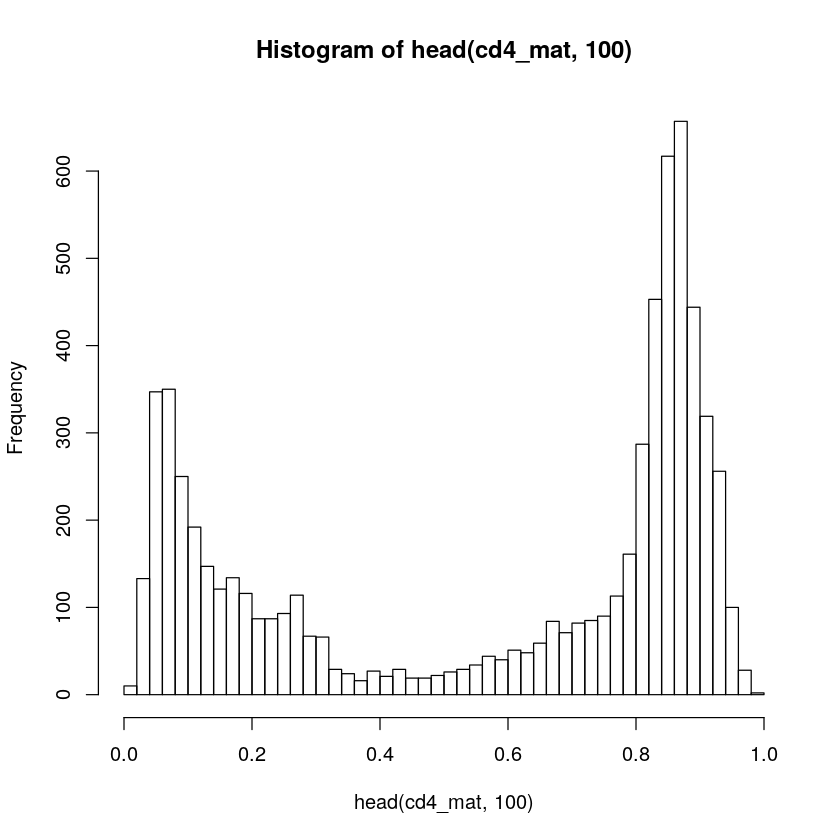

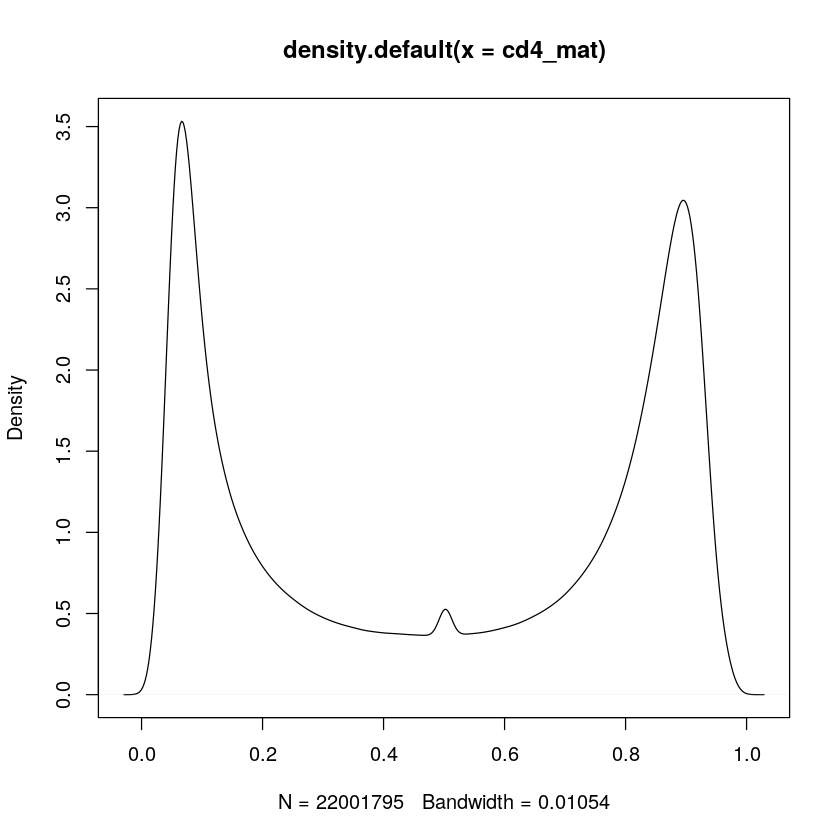

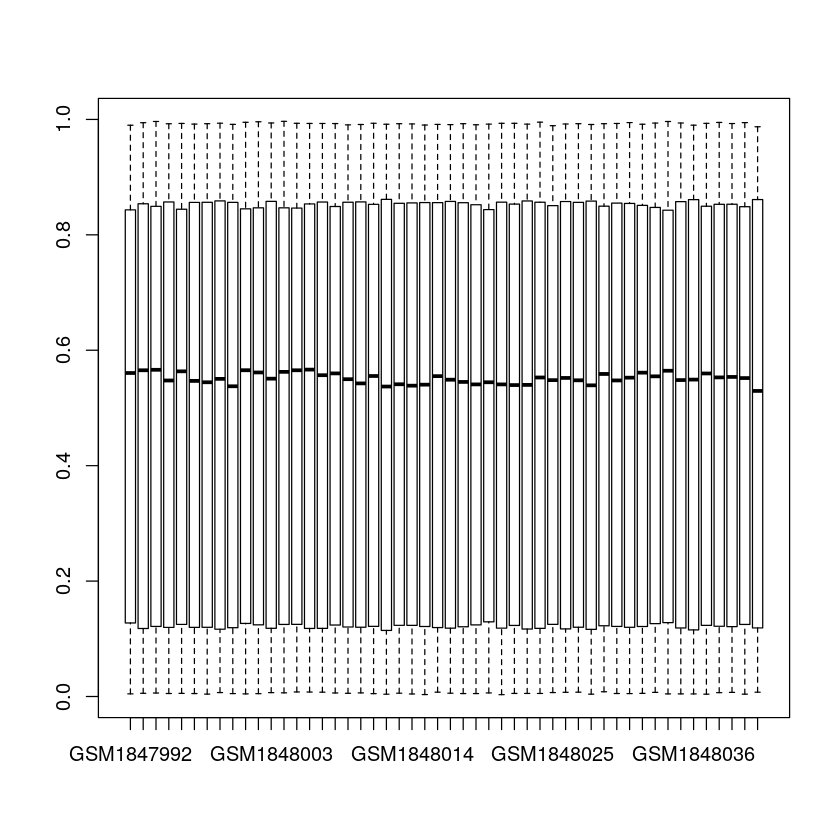

In [63]:
range(cd4_mat)
hist(head(cd4_mat, 100), breaks=50)
plot(density(cd4_mat))
boxplot(cd4_mat[,1:50])


# Prior to finding differentially methylated sites, the methylation values of each CpG site were corrected by fitting a linear model with age, sex, methylation bead array chip and array row on the chip as covariates.

In [5]:
combat_cd8_mat <- ComBat(dat = cd8_mat, batch = cd8_key$age, 
                     mod = model.matrix(~as.factor(diagnosis),
                                      data=cd8_key),
                     par.prior=TRUE, prior.plots=FALSE)

Found37batches
Note: one batch has only one sample, setting mean.only=TRUE
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [6]:
head(cd8_mat, 5)
head(combat_cd8_mat,5)

,GSM1848063,GSM1848065,GSM1848068,GSM1848070,GSM1848071,GSM1848072,GSM1848073,GSM1848074,GSM1848075,GSM1848076,...,GSM1848125,GSM1848126,GSM1848127,GSM1848128,GSM1848129,GSM1848130,GSM1848131,GSM1848132,GSM1848133,GSM1848134
cg00000029,0.6230955,0.7305771,0.7188707,0.7397200,0.7400317,0.7116196,0.6773810,0.6559004,0.7022973,0.7273144,...,0.7317703,0.6066616,0.6687542,0.6851246,0.6411103,0.6600936,0.6927672,0.5998506,0.6549124,0.6464985
cg00000165,0.2850181,0.2673007,0.2830329,0.2720503,0.2422538,0.2895959,0.3227511,0.2454971,0.3388622,0.3536687,...,0.2705401,0.3058952,0.2573734,0.3625476,0.3735513,0.2549220,0.2344297,0.2851157,0.2767348,0.3425648
cg00000236,0.8674554,0.8465983,0.8390820,0.8691962,0.8690748,0.8745982,0.8374156,0.8528251,0.8717207,0.8647851,...,0.8975462,0.7696826,0.8282152,0.8304289,0.8561097,0.8383581,0.8133452,0.8100074,0.8274307,0.8297456
cg00000289,0.5929520,0.6267766,0.5997672,0.6720554,0.6231661,0.6615208,0.6760411,0.7237696,0.6310488,0.6750161,...,0.5462894,0.6545747,0.6653911,0.5345543,0.6078303,0.6448371,0.6843967,0.7144998,0.6938663,0.5793450
cg00000363,0.4617321,0.4289924,0.4937326,0.4037695,0.4295057,0.4775721,0.4213711,0.4059587,0.4445547,0.4166180,...,0.4546863,0.4787887,0.3913858,0.4616875,0.4138345,0.4822160,0.4419263,0.4305170,0.4319359,0.5267727


,GSM1848063,GSM1848065,GSM1848068,GSM1848070,GSM1848071,GSM1848072,GSM1848073,GSM1848074,GSM1848075,GSM1848076,...,GSM1848125,GSM1848126,GSM1848127,GSM1848128,GSM1848129,GSM1848130,GSM1848131,GSM1848132,GSM1848133,GSM1848134
cg00000029,0.6203648,0.7182062,0.7083657,0.7099486,0.7276608,0.6999082,0.6650101,0.6798521,0.6935323,0.7337157,...,0.6741129,0.6392339,0.6529824,0.6823939,0.6520730,0.6495885,0.6769954,0.6354255,0.6401851,0.6512534
cg00000165,0.2772515,0.2752825,0.2991042,0.2862524,0.2502356,0.2829333,0.3307329,0.2821096,0.3081541,0.3345168,...,0.2914282,0.3004683,0.2873597,0.3547811,0.3113580,0.2709932,0.2644160,0.2935029,0.2939871,0.3369698
cg00000236,0.8666042,0.8497590,0.8437146,0.8630184,0.8722355,0.8715520,0.8405763,0.8565717,0.8627008,0.8714202,...,0.8513895,0.8149583,0.8363873,0.8295777,0.8390699,0.8429907,0.8215173,0.8265282,0.8279266,0.8312827
cg00000289,0.6048901,0.6193616,0.6101379,0.6451409,0.6157511,0.6556522,0.6686261,0.6508826,0.6284747,0.6637474,...,0.6274620,0.6545426,0.6534344,0.5464923,0.6471007,0.6552077,0.6724400,0.6743559,0.6841779,0.5777657
cg00000363,0.4545016,0.4318915,0.4682718,0.4217569,0.4324048,0.4763908,0.4242702,0.4258363,0.4375397,0.4090658,...,0.4549814,0.4619316,0.4130256,0.4544570,0.4479943,0.4567552,0.4635661,0.4461406,0.4412750,0.5212534


In [7]:
combat_cd4_mat <- ComBat(dat = cd4_mat, batch = cd4_key$age, 
                     mod = model.matrix(~as.factor(diagnosis),
                                      data=cd4_key),
                     par.prior=TRUE, prior.plots=FALSE)

Found37batches
Note: one batch has only one sample, setting mean.only=TRUE
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [8]:
head(cd4_mat, 5)
head(combat_cd4_mat,5)

,GSM1847992,GSM1847993,GSM1847994,GSM1847995,GSM1847996,GSM1847997,GSM1847998,GSM1847999,GSM1848000,GSM1848001,...,GSM1848049,GSM1848050,GSM1848051,GSM1848052,GSM1848053,GSM1848054,GSM1848055,GSM1848056,GSM1848057,GSM1848060
cg00000029,0.6891052,0.6855117,0.7597718,0.6572791,0.6340425,0.7258857,0.6561995,0.6140348,0.6705295,0.7232441,...,0.6773344,0.7390622,0.6644878,0.7536970,0.7085601,0.6274526,0.6451463,0.6819983,0.6559495,0.7297607
cg00000165,0.3040812,0.2756206,0.2609209,0.2673450,0.2699676,0.2554553,0.2899948,0.2448319,0.3397843,0.2655507,...,0.2563061,0.2766614,0.2077699,0.2883459,0.3135418,0.2750509,0.2564614,0.2627127,0.2290870,0.3314362
cg00000236,0.8410680,0.8732100,0.8568683,0.8591934,0.8731590,0.8945298,0.8210283,0.8828818,0.8472972,0.8646884,...,0.8434471,0.8552659,0.8225502,0.8603409,0.8555995,0.8715566,0.8056327,0.8609750,0.8741843,0.8587779
cg00000289,0.5805570,0.6758169,0.6206408,0.7337596,0.6082721,0.6131171,0.7573842,0.6958804,0.6061886,0.5811683,...,0.6720100,0.5659503,0.6189792,0.7366446,0.5615902,0.5914943,0.7313404,0.5841068,0.5088171,0.6770974
cg00000363,0.4568008,0.3914820,0.4768944,0.4162306,0.4382134,0.4128829,0.4240806,0.4203584,0.4251908,0.4557418,...,0.4368783,0.3909104,0.4675140,0.4249935,0.4631724,0.3905925,0.4077969,0.4144806,0.4420411,0.4313618


,GSM1847992,GSM1847993,GSM1847994,GSM1847995,GSM1847996,GSM1847997,GSM1847998,GSM1847999,GSM1848000,GSM1848001,...,GSM1848049,GSM1848050,GSM1848051,GSM1848052,GSM1848053,GSM1848054,GSM1848055,GSM1848056,GSM1848057,GSM1848060
cg00000029,0.6773983,0.6977632,0.7455206,0.6727052,0.6462940,0.7148425,0.6684510,0.6625393,0.6608625,0.7196787,...,0.6690426,0.6889339,0.6732893,0.7309804,0.6968531,0.6629264,0.6308951,0.6592817,0.6722670,0.7200937
cg00000165,0.2923207,0.2749343,0.2727350,0.2739615,0.2692813,0.2511076,0.2893086,0.2683997,0.3121977,0.2721113,...,0.2541080,0.2787642,0.2574044,0.2903798,0.3017813,0.2781938,0.2682754,0.2647466,0.2677943,0.3038497
cg00000236,0.8418222,0.8802394,0.8774683,0.8654301,0.8801884,0.8894702,0.8280577,0.8727738,0.8537250,0.8618062,...,0.8369691,0.8606413,0.8498851,0.8610082,0.8563538,0.8648048,0.8262327,0.8616423,0.8647222,0.8652058
cg00000289,0.5949879,0.6562364,0.6075054,0.6779016,0.5886916,0.6098047,0.7378037,0.6592515,0.6134331,0.5983611,...,0.6696267,0.6455134,0.6504967,0.7387621,0.5760210,0.6435080,0.7182049,0.5862243,0.6287609,0.6843420
cg00000363,0.4483779,0.4092448,0.4783966,0.4383119,0.4559762,0.4253772,0.4418434,0.4422867,0.4340977,0.4703243,...,0.4194186,0.4301462,0.4480841,0.4358850,0.4547495,0.4254922,0.4092991,0.4253721,0.4400225,0.4402687


# Save normalized data for future use


In [9]:
cd8_mat <- combat_cd8_mat
cd4_mat <- combat_cd4_mat

In [10]:
# save(cd8_geo, cd8_key, cd8_mat, anno, file="CD8.RData")
# save(cd4_geo, cd4_key, cd4_mat, anno, file="CD4.RData")


In [32]:
load("CD8.RData")
load("CD4.RData")

In [33]:
dim(cd4_mat)
dim(cd8_mat)

[1] 328385     67

[1] 328385     68

In [34]:
load("genome_information.RData")

In [35]:
head(genome_information)

GRanges object with 6 ranges and 3 metadata columns:
             seqnames    ranges strand | UCSC_RefGene_Group
                <Rle> <IRanges>  <Rle> |           <factor>
  cg13869341        1     15865      * |               Body
  cg14008030        1     18827      * |               Body
  cg12045430        1     29407      * |             TSS200
  cg20826792        1     29425      * |             TSS200
  cg00381604        1     29435      * |             TSS200
  cg20253340        1     68849      * |            TSS1500
             Relation_to_UCSC_CpG_Island UCSC_RefGene_Name
                                <factor>          <factor>
  cg13869341                                        WASH5P
  cg14008030                                        WASH5P
  cg12045430                      Island            WASH5P
  cg20826792                      Island            WASH5P
  cg00381604                      Island            WASH5P
  cg20253340                                         O

# The model residuals were used for differential methylation analysis with the R package “seqlm” (https://github.com/raivokolde/seqlm) by applying the statistical test to single CpG sites (argument max_dist = 1). Single CpGs with a false discovery rate (FDR) < 0.005 and an absolute methylation difference of >0.5 were considered as differentially methylated and used in downstream analyses.

# CD4

In [69]:
library(doParallel)
registerDoParallel(cores = 4)
cd4_cpg = seqlm(values = cd4_mat,
                 genome_information = genome_information,
                 annotation = cd4_key$diagnosis,
                 max_dist = 1
            )

Finding the best segmentation
  |======================================================================| 100%
Calculating coefficients and p-values for all regions
Adding additional information to the results
	All numeric variables
	Variable: UCSC_RefGene_Group
	Variable: Relation_to_UCSC_CpG_Island
	Variable: UCSC_RefGene_Name


In [70]:
cd4_healthy_geo <- filter(cd4_key, diagnosis == 'Healthy')$geo
cd4_graves_geo <- filter(cd4_key, diagnosis != 'Healthy')$geo

In [71]:
healthy_cd4 <- as.data.frame(cd4_mat) %>% select(cd4_healthy_geo) %>%
            mutate("cg" = rownames(cd4_mat), "mean" = apply(., 1, mean)) %>% 
            select(cg,mean)

graves_cd4 <- as.data.frame(cd4_mat) %>% select(cd4_graves_geo) %>%
            mutate("cg" = rownames(cd4_mat), "mean" = apply(., 1, mean)) %>% 
            select(cg,mean)

In [72]:
head(healthy_cd4)
head(graves_cd4)

cg,mean
cg00013349,0.5288105
cg00027674,0.3485258
cg00030296,0.7642436
cg00031346,0.4480995
cg00032884,0.1900744
cg00033909,0.4013778


cg,mean
cg00013349,0.5928342
cg00027674,0.2971105
cg00030296,0.7087070
cg00031346,0.5044780
cg00032884,0.2848074
cg00033909,0.4652940


0%        25%        50%        75%       100% 
0.05000140 0.05348687 0.05816718 0.06544183 0.19940579

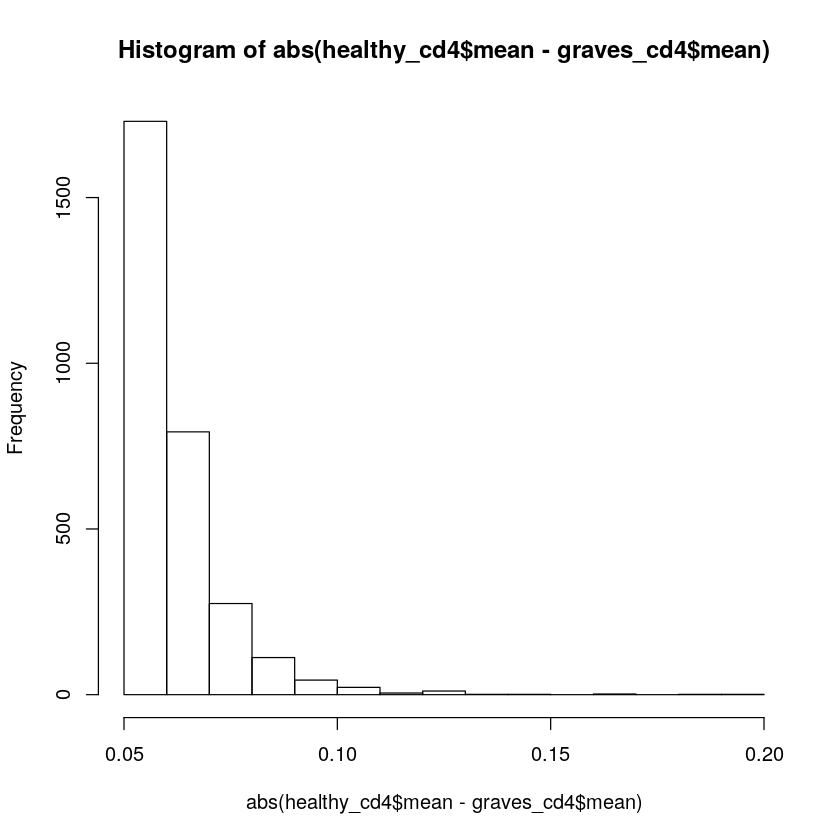

In [73]:
hist(abs(healthy_cd4$mean - graves_cd4$mean))
quantile(abs(healthy_cd4$mean - graves_cd4$mean))

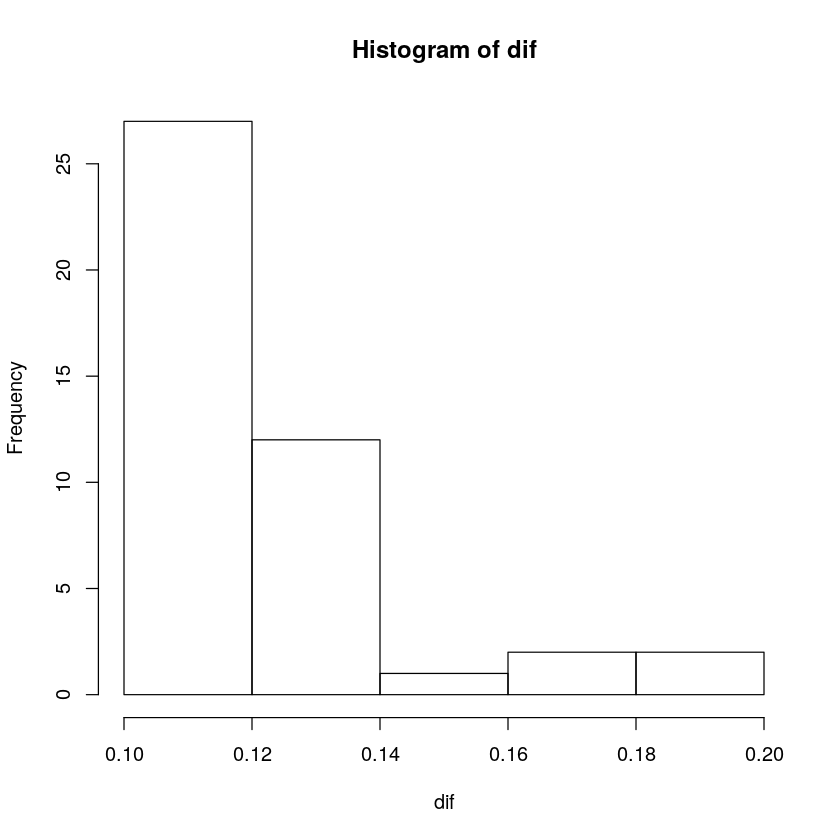

In [75]:
dif <- abs(healthy_cd4$mean - graves_cd4$mean)
dif <- dif[abs(healthy_cd4$mean - graves_cd4$mean) > 0.1]
hist(dif)
good_cg <- names(dif)

In [76]:
length(good_cg)
head(good_cg)

[1] 44

[1] "cg00142257" "cg00278517" "cg00434573" "cg00713939" "cg01048962"
[6] "cg01097406"

In [77]:
length(cd4_cpg)
cd4_cpg <- as.data.frame(cd4_cpg) %>% 
            filter(fdr < 0.005 & probes %in% good_cg)
nrow(cd4_cpg)

NULL

[1] 44

In [78]:
cd4_mat <- as.data.frame(cd4_mat) %>%
    mutate("probe" = rownames(cd4_mat)) %>%
    filter(probe %in% cd4_cpg$probes)

rownames(cd4_mat) <- cd4_mat$probe
cd4_mat <- cd4_mat[, -ncol(cd4_mat)]

In [79]:
nrow(cd4_mat)
nrow(cd4_cpg)
head(cd4_mat)

[1] 44

[1] 44

,GSM1847992,GSM1847993,GSM1847994,GSM1847995,GSM1847996,GSM1847997,GSM1847998,GSM1847999,GSM1848000,GSM1848001,...,GSM1848049,GSM1848050,GSM1848051,GSM1848052,GSM1848053,GSM1848054,GSM1848055,GSM1848056,GSM1848057,GSM1848060
cg00142257,0.4122434,0.51848479,0.5627227,0.4864585,0.43132955,0.4655618,0.2736042,0.4512010,0.4903609,0.4842979,...,0.4550577,0.3888627,0.3300178,0.4132906,0.3533048,0.3874663,0.2014735,0.3608188,0.3658812,0.4305409
cg00278517,0.4734909,0.56870903,0.5864801,0.4977508,0.61375932,0.5986472,0.3864627,0.5558569,0.3906072,0.5363274,...,0.3943654,0.4643582,0.4160098,0.2739826,0.4406790,0.4058805,0.3876892,0.5278583,0.4377678,0.3870135
cg00434573,0.1324254,0.06301471,0.2179613,0.2539216,0.07891445,0.1394645,0.4025510,0.2249080,0.1371391,0.1095276,...,0.3971105,0.2443950,0.3245176,0.3907705,0.3097491,0.2774304,0.3356800,0.2204513,0.2749134,0.2821024
cg00713939,0.5915280,0.40511920,0.3330917,0.3892111,0.35573431,0.3396973,0.4326223,0.4335259,0.5113681,0.4467421,...,0.3331605,0.2839870,0.3387895,0.1722797,0.3214660,0.3298554,0.2776124,0.3641307,0.3506712,0.1531135
cg01048962,0.2918673,0.26409069,0.3297317,0.3026134,0.22706921,0.2231443,0.2139209,0.2612447,0.3789088,0.4766465,...,0.1861795,0.1782653,0.1681313,0.2233711,0.1417084,0.1943730,0.1181600,0.1298053,0.1705151,0.1619550
cg01097406,0.5022061,0.26017662,0.4084823,0.4213126,0.50927483,0.4837898,0.3840635,0.4079091,0.5392230,0.5986150,...,0.4954056,0.5096875,0.5764819,0.4853262,0.3038401,0.5456257,0.6420682,0.5459061,0.4927699,0.5908122


In [80]:
cd4_anno <- anno %>% filter(Name %in% rownames(cd4_mat))
nrow(cd4_anno)

[1] 44

In [81]:
save(cd4_mat, cd4_anno, cd4_key, cd4_cpg, file="sig_cd4.RData")

# CD8

In [82]:
library(doParallel)
registerDoParallel(cores = 4)
cd8_cpg = seqlm(values = cd8_mat,
                 genome_information = genome_information,
                 annotation = cd8_key$diagnosis,
                 max_dist = 1
            )

Finding the best segmentation
  |======================================================================| 100%
Calculating coefficients and p-values for all regions
Adding additional information to the results
	All numeric variables
	Variable: UCSC_RefGene_Group
	Variable: Relation_to_UCSC_CpG_Island
	Variable: UCSC_RefGene_Name


In [83]:
cd8_healthy_geo <- filter(cd8_key, diagnosis == 'Healthy')$geo
cd8_graves_geo <- filter(cd8_key, diagnosis != 'Healthy')$geo

In [84]:
healthy_cd8 <- as.data.frame(cd8_mat) %>% select(cd8_healthy_geo) %>%
            mutate("cg" = rownames(cd8_mat), "mean" = apply(., 1, median)) %>% 
            select(cg,mean)

graves_cd8 <- as.data.frame(cd8_mat) %>% select(cd8_graves_geo) %>%
            mutate("cg" = rownames(cd8_mat), "mean" = apply(., 1, median)) %>% 
            select(cg,mean)

In [85]:
head(healthy_cd8)
head(graves_cd8)

cg,mean
cg00001874,0.7552457
cg00004105,0.5867964
cg00005166,0.8484415
cg00005619,0.7712057
cg00009088,0.8491304
cg00010853,0.2368261


cg,mean
cg00001874,0.6983105
cg00004105,0.5259174
cg00005166,0.7624492
cg00005619,0.6837482
cg00009088,0.7605100
cg00010853,0.3086200


0%        25%        50%        75%       100% 
0.05000418 0.05877463 0.07033111 0.08800722 0.21092515

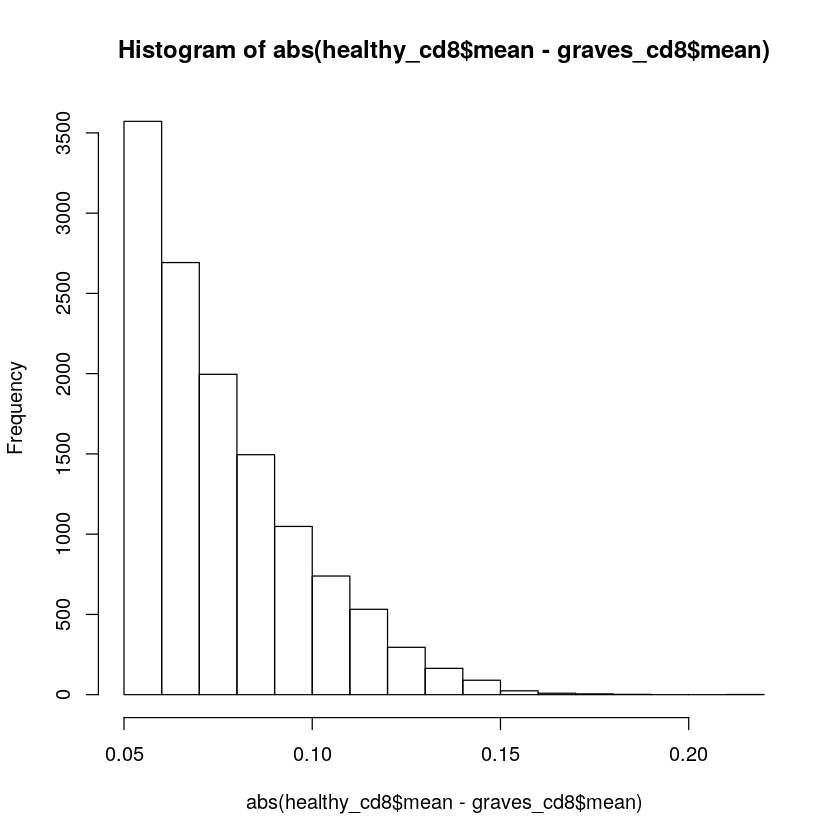

In [86]:
hist(abs(healthy_cd8$mean - graves_cd8$mean))
quantile(abs(healthy_cd8$mean - graves_cd8$mean))

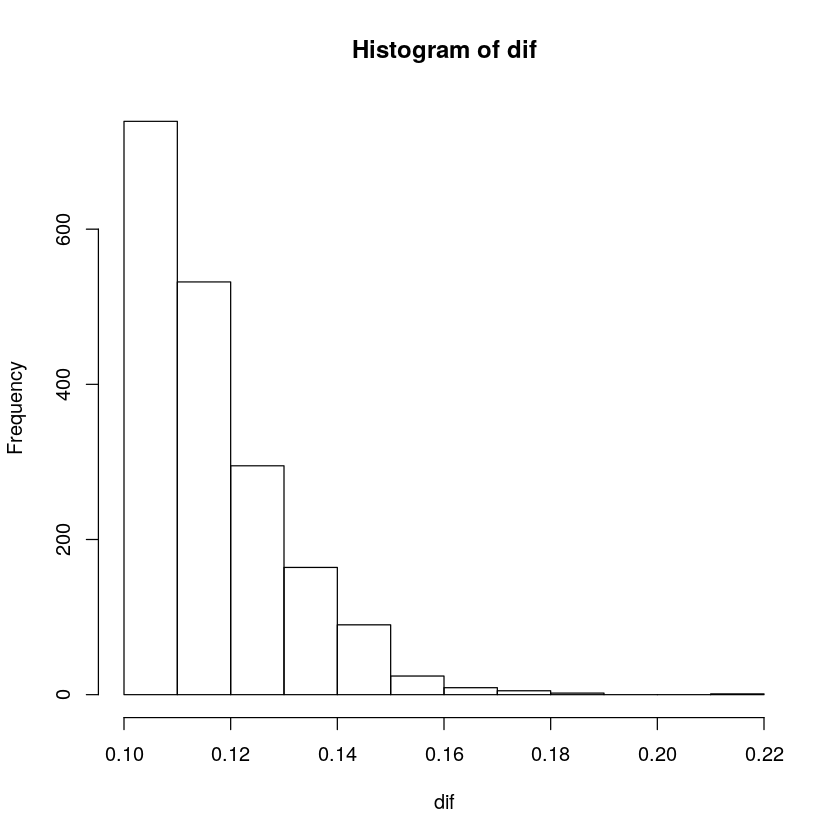

In [87]:
dif <- abs(healthy_cd8$mean - graves_cd8$mean)
dif <- dif[abs(healthy_cd8$mean - graves_cd8$mean) > 0.1]
hist(dif)
good_cg <- names(dif)

In [88]:
length(good_cg)
head(good_cg)

[1] 1861

[1] "cg00030296" "cg00032884" "cg00050618" "cg00060800" "cg00067720"
[6] "cg00071250"

In [89]:
length(cd8_cpg)
cd8_cpg <- as.data.frame(cd8_cpg) %>% 
            filter(fdr < 0.005 & probes %in% good_cg)
nrow(cd8_cpg)

[1] 12664

[1] 1861

In [90]:
cd8_mat <- as.data.frame(cd8_mat) %>%
    mutate("probe" = rownames(cd8_mat)) %>%
    filter(probe %in% cd8_cpg$probes)

rownames(cd8_mat) <- cd8_mat$probe
cd8_mat <- cd8_mat[, -ncol(cd8_mat)]

In [91]:
nrow(cd8_mat)
nrow(cd8_cpg)
head(cd8_mat)

[1] 1861

[1] 1861

,GSM1848063,GSM1848065,GSM1848068,GSM1848070,GSM1848071,GSM1848072,GSM1848073,GSM1848074,GSM1848075,GSM1848076,...,GSM1848125,GSM1848126,GSM1848127,GSM1848128,GSM1848129,GSM1848130,GSM1848131,GSM1848132,GSM1848133,GSM1848134
cg00030296,0.5819730,0.7000241,0.6787659,0.6775437,0.6874588,0.6989493,0.5927803,0.6633103,0.6598131,0.6228217,...,0.6070729,0.5461209,0.5552922,0.6499495,0.5716758,0.5405086,0.5750685,0.5460917,0.6193233,0.4981104
cg00032884,0.5839259,0.2708649,0.2913396,0.2850249,0.2359946,0.2142949,0.4047235,0.3114423,0.2999232,0.3451976,...,0.3912286,0.5023169,0.4718681,0.4193616,0.4389078,0.5084795,0.4062710,0.4969969,0.3632756,0.5013552
cg00050618,0.6676749,0.2976384,0.3385806,0.3362445,0.3110799,0.2269623,0.5119304,0.3672786,0.3736005,0.4591961,...,0.4439383,0.5518911,0.5069147,0.5549712,0.4978740,0.6026100,0.4284513,0.5418459,0.3983515,0.5969988
cg00060800,0.7201319,0.8661110,0.8155584,0.8185539,0.8181838,0.8504944,0.7016773,0.7878172,0.7955811,0.8310020,...,0.7282938,0.6537733,0.6271951,0.8362673,0.7004504,0.6718952,0.7376825,0.6411493,0.7434889,0.6408523
cg00067720,0.5904981,0.7546022,0.6948224,0.7111202,0.7031895,0.7386855,0.5768486,0.6655363,0.7058848,0.7232743,...,0.6248924,0.5553287,0.5735721,0.7242167,0.6121886,0.5503200,0.5750277,0.5396132,0.6379150,0.5640426
cg00071250,0.4328201,0.2367063,0.2603586,0.2420195,0.1880294,0.1647356,0.3796386,0.2708342,0.2685779,0.3103581,...,0.3332989,0.4212897,0.4003549,0.4055322,0.3860812,0.4419740,0.3842102,0.4285783,0.3409449,0.4910761


In [92]:
cd8_anno <- anno %>% filter(Name %in% rownames(cd8_mat))
nrow(cd8_anno)

[1] 1861

In [93]:
save(cd8_mat, cd8_anno, cd8_key, cd8_cpg, file="sig_cd8.RData")